In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ase
import glob
import numpy as np
from toolz.curried import pipe, curry

In [3]:
try:
    import pyfftw
    np.fftpack = pyfftw.interfaces.numpy_fft
    pyfftw.interfaces.cache.enable()
except ImportError:
    print("you can install PyFFTW for speed-up as - ")
    print("conda install -c conda-forge pyfftw")
    pass

In [4]:
import filters
import utilities as utils
import atom_stat as astat

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

## Import tools for generating Standard Structures

In [6]:
from ase.lattice.cubic import FaceCenteredCubic
from ase.lattice.cubic import BodyCenteredCubic
from ase.lattice.cubic import SimpleCubic
from ase.lattice.hexagonal import HexagonalClosedPacked

In [39]:
atoms = FaceCenteredCubic(directions=[[0,0,1], [0,1,0], [-1,0,0]], size=(5,5,5), symbol='Cu', pbc=(1,1,1))
# atom = BodyCenteredCubic(directions=[[0,0,1], [0,1,0], [-1,0,0]], size=(10,10,10), symbol='Fe', pbc=(1,1,1))
# atom = SimpleCubic(directions=[[0,0,1], [0,1,0], [-1,0,0]], size=(12,12,12), symbol='Cu', pbc=(1,1,1), latticeconstant=1.0)
# atom = HexagonalClosedPacked(directions=[[0,0,0,1], [1,-1,0,0], [1,1,-2,0]], size=(8,8,8), symbol='Co', pbc=(1,1,1))

In [12]:
%%time
from ase.build import bulk
atoms = bulk('Cu', 'fcc', a=3.6, cubic=True).repeat([5]*3)

print("No. of atoms in the structure: {}".format(len(atoms)))

print("dimensions of the unit cell: {}".format(atoms.get_cell()))

No. of atoms in the structure: 500
dimensions of the unit cell: Cell([18.0, 18.0, 18.0])
CPU times: user 2.94 ms, sys: 1.07 ms, total: 4 ms
Wall time: 3.09 ms


In [15]:
coords_all = atoms.get_positions() 
coords_qry = coords_all.copy()

### parameters for computing the statistics

In [16]:
cutoff = 9.0
r_stat = 5.0
len_pixel = 10.0

## Compute a KDtree for the atom-positions while accounting for the relevant periodic boundary conditions

In [17]:
%%time
tree = astat.get_kdTree(coords_all, 
                        cell_dim=atoms.get_cell_lengths_and_angles(), 
                        cutoff=cutoff)

CPU times: user 127 ms, sys: 36.7 ms, total: 163 ms
Wall time: 210 ms


## Compute neighbor indices for a subset of coordinates whose neighborhood statistics we intend to evaluate

In [18]:
%%time
indexes = tree.search_tree(coords_qry, radius=r_stat)

CPU times: user 27 ms, sys: 1.21 ms, total: 28.2 ms
Wall time: 27.4 ms


## Compute real space statistics coordinates

In [19]:
%%time
coords_stat = astat.get_realStats(coords_all, coords_qry, indexes, r_stat=r_stat, 
                            cell=atoms.get_cell(), 
                            pbc=atoms.get_pbc())

CPU times: user 20.8 ms, sys: 1.98 ms, total: 22.8 ms
Wall time: 7.04 ms


# Compute RDF

### Given the real space statistics coordinates, compute number count and RDF 

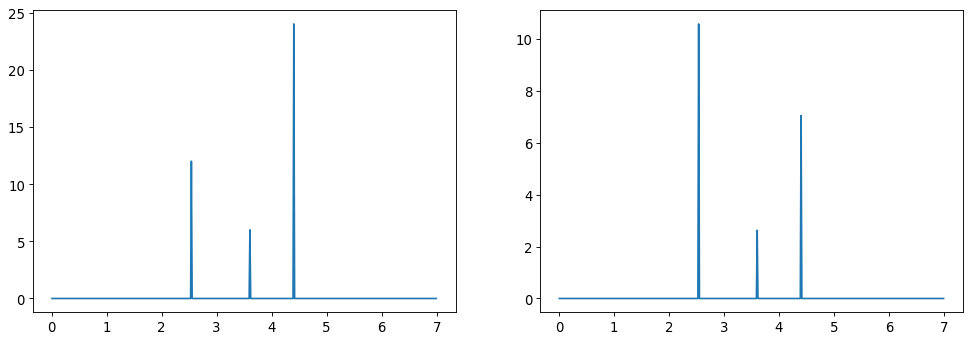

CPU times: user 212 ms, sys: 5.24 ms, total: 217 ms
Wall time: 217 ms


In [20]:
%%time
rdf, pdf, bin_centers = astat.get_rdf(coords_stat, r_stat, len_pixel*10)

fig, axs = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(15,5))
axs[0].plot(bin_centers, rdf)
axs[1].plot(bin_centers, pdf)

for ax in axs:
    ax.grid(False)
plt.show()

### Generate a one-d smoothening kernel

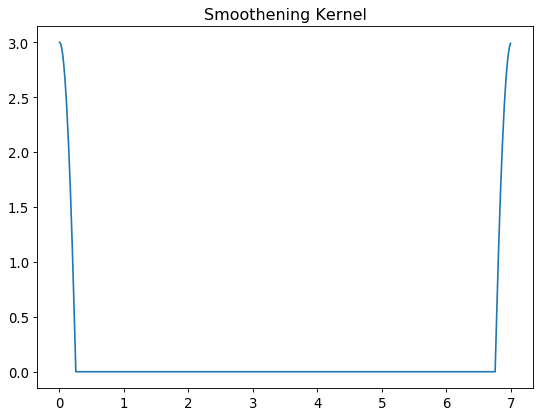

In [21]:
kernel = filters.epanechnikov_kernel(width=0.25, x=bin_centers)

plt.plot(bin_centers, kernel)
plt.title("Smoothening Kernel")
plt.grid(False)
plt.show()

### Apply the smoothening kernel to the RDF to get a smooth signal

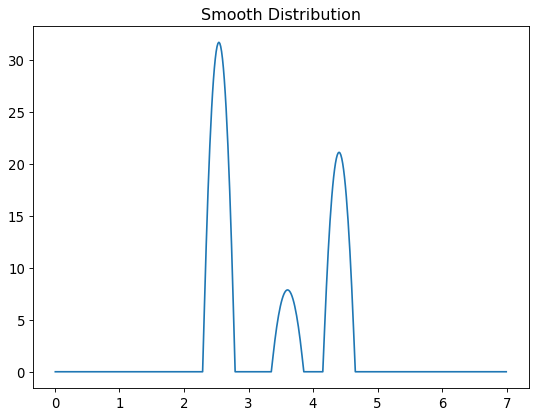

In [22]:
new_pdf = filters.convolve_kernel(kernel, pdf)

plt.plot(bin_centers, new_pdf)
plt.title("Smooth Distribution")
plt.grid(False)
plt.show()

# Compute two-point statistics

### Compute the vector counts and save them in a matrix called box

In [23]:
%%time
box = astat.get_2ptStat(coords_stat, r_stat, len_pixel)
print("shape of the stat box: {}".format(box.shape))

shape of the stat box: (101, 101, 101)
CPU times: user 247 ms, sys: 16.8 ms, total: 264 ms
Wall time: 264 ms


/Users/apaarshanker/anaconda3/envs/atommks/lib/python3.6/site-packages/numba/core/typed_passes.py:314: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "atom_stat.py", line 99:
@numba.njit(parallel=True)
def box_count(box, indexes, N, shape):
^

  state.func_ir.loc))


## Visualize the vector counts in X, Y and Z direction respectively 

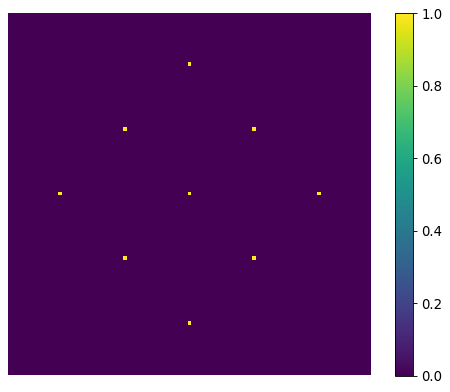

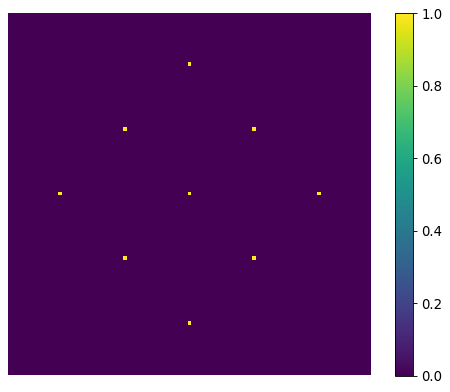

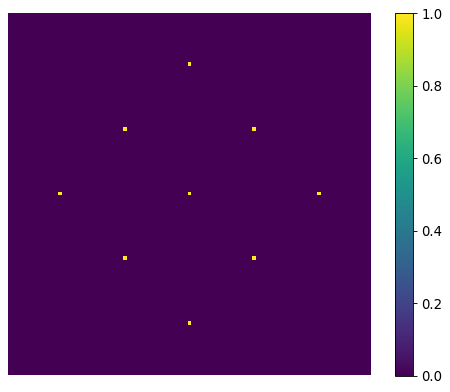

In [25]:
idx = int(r_stat * len_pixel)

utils.draw_im(box[idx,:,:])

utils.draw_im(box[:,idx,:])

utils.draw_im(box[:,:,idx])

### Generate a smoothening filter of appropriate size to smoothen the above statistics

In [ ]:
r_s = 1.0 # radius of the smoothening filter
new_shape = np.asarray(box.shape) + int(2 * r_s * len_pixel)

fs = pipe(r_s, 
          lambda r_s: filters.sphere(r_s * len_pixel),
          lambda s: utils.padder(s, new_shape), 
          lambda s: filters.imfilter(arg1=s, arg2=s) / np.count_nonzero(s))

### Visualize the smoothening filter

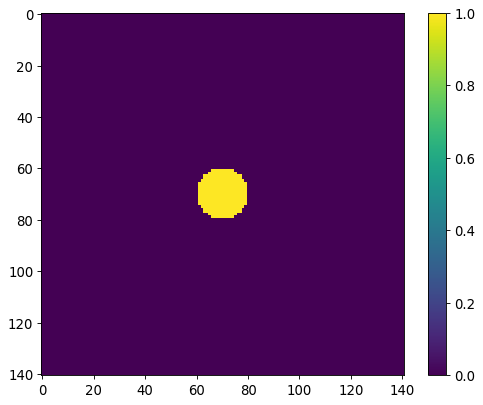

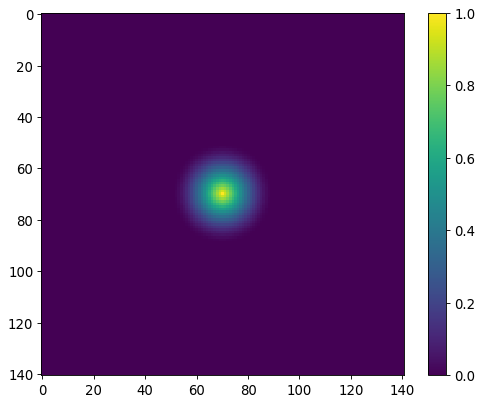

In [16]:
idx = int((r_stat + r_s) * len_pixel)
utils.draw_im((fs[:,:, idx]))

## Apply the filter to the voxelized, computed statistics

In [14]:
%%time
box1 = pipe(box, 
            lambda s: utils.padder(s, new_shape), 
            lambda s: filters.imfilter(arg1=s, arg2=fs))

(141, 141, 141)
CPU times: user 555 ms, sys: 52.3 ms, total: 607 ms
Wall time: 306 ms


## Visualization of the smooth statistics

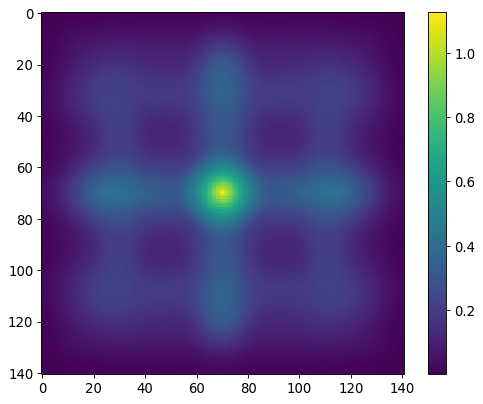

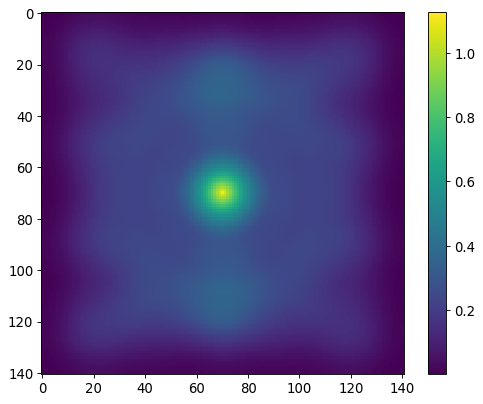

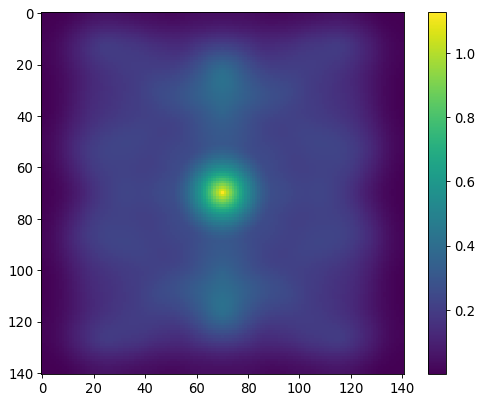

In [17]:
idx = int((r_stat + r_s) * len_pixel)
utils.draw_im(box1[:,:,idx])

## How to convert a real space lattice to fractional space and then back?

Let's say, we have a particle at a position $\vec{\textbf r}$ and the lattice vectors, i.e. the vectors that form the sides of the simulation cell $\textbf a_i$. We can express $\textbf r$ in the basis of $\textbf a_i$:  
  
  
  $r = \sum_i f_i \textbf a_i$
  
You can express as a matrix-vector multiplication:  
  
  $\textbf r = \textbf{Af}$
  
where A is a matrix whose columns are the lattice vectors, and it can be seen that f are the fractional coordinates. So defining $\textbf A = \textbf B^{-1}$ one can find the fractional coordinates of $\textbf r$ simply by  
    
  $\textbf f = \textbf{Br}$
  
Now, if one wants all the images be be in the same cell, we can achieve this by ensuring $0 \leq f_i \leq 1$, and to achieve this we can simple modify $f_i$ to be $f_i - floor(f_i)$ and this simply translates particles to equivalent position in the reference cell under the assumption of periodic boundary conditions. So for arbitrary cell (in arbitrary dimensionality) the recipe is,

 - form $\textbf A$
 - invert $\textbf A$ to form $\textbf B$
 - From the position of a particle at $\textbf r$ get the fractional coordinates $\textbf f$ as $\textbf f = \textbf{Br}$
 - rescale fractional coordinates to fall within the reference cell as $g_i = f_i - floor(f_i)$
 - get the new position in real space $\textbf t$ as $\textbf t = \textbf{Ag}$